In [11]:
from fastai.text.all import *
import pandas as pd
cols = ["sentiment","text"]
df = pd.read_csv("data/all-data.csv", names =cols, encoding = "ISO-8859-1")
df_test = pd.read_csv("data/public-test-set.csv", names = cols, encoding = "ISO-8859-1")

In [12]:
df['is_valid'] = False
df_test['is_valid'] = True

In [13]:
#helper functions:
def gen_sentence(preface_text):
    N_WORDS = 50
    N_SENTENCES = 2
    preds = [learn.predict(preface_text, n_words = N_WORDS, temperature=0.75) 
             for _ in range(N_SENTENCES)]
    return("\n\n".join(preds))

In [14]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

### Preproc

In [15]:
def clean_text(in_df):
    #Remove words which have numbers in them
    in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
    #Remove words which have special characters, except newline, space
    in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')

#clean_text(df_test)
#clean_text(df)

    #Filter out rows which are almost empty
#mask_df = (df['text'].apply(lambda x: True if len(x.split(" ")) > 3 else False))
#mask_test = (df_test['text'].apply(lambda x: True if len(x.split(" ")) > 3 else False))
    
#df = df[mask_df]
#df_test = df_test[mask_test]

In [16]:
df_all = pd.concat([df, df_test])

### Language Model

In [17]:
dls_lm = TextDataLoaders.from_df(df_all, is_lm=True, valid_pct=0.1, text_col='text')
learn = language_model_learner(dls_lm, AWD_LSTM, pretrained = True, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [18]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.936148,4.122833,0.273996,61.733902,00:12
1,4.347153,3.961156,0.291884,52.518009,00:11


In [19]:
learn.unfreeze()
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.930610,3.798304,0.320189,44.625427,00:13
1,3.763212,3.655495,0.339317,38.686672,00:13
2,3.605617,3.555024,0.352369,34.988647,00:13
3,3.447639,3.499933,0.361111,33.113224,00:13
4,3.325398,3.479173,0.362289,32.432903,00:13
5,3.251664,3.477992,0.363529,32.394604,00:13


In [20]:
learn.save('min_finetuned')
learn.save_encoder('min_finetuned_enc')

In [21]:
print(gen_sentence("The sales were"))

The sales were also slightly lower than in the previous year , which was expected to be slightly lower than in the corresponding period in 2005 . The sale will have some effect on the company 's ongoing operations , and the company will transfer its stake in Nordic

The sales were expected to rise by 6 % in the second quarter of 2008 , and the company said that it will be able to expand the production capacity of Biohit Oyj 's Nordic plant in Estonia , Finland and the Baltic countries . $


### Classifier

In [22]:
dls_clas = TextDataLoaders.from_df(df_all, seed = 7, text_col='text', label_col="sentiment", text_vocab=dls_lm.vocab, valid_col='is_valid')
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn = learn.load_encoder('min_finetuned_enc')

In [23]:
#learn.lr_find()

In [24]:
#learn.recorder.plot_loss(with_valid = True)

In [25]:
#learn.dls.train.items #correct

In [26]:
#learn.dls.valid.items #correct

In [27]:
learn.fit_one_cycle(3, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.789457,1.483460,0.362837,00:05
1,0.679413,1.609694,0.347011,00:05
2,0.603331,1.906063,0.350723,00:05


In [28]:
learn.freeze_to(-2)

In [29]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.618816,2.014974,0.342712,00:05


In [30]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.535750,1.840400,0.348183,00:06


In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.434992,2.061167,0.352481,00:08
1,0.381904,2.074018,0.353263,00:07


In [32]:
learn.save('min_finished')

Path('models/min_finished.pth')

### See results

In [33]:
print("Test Set Accuracy: ",learn.validate()[1]) #0.712

Test Set Accuracy:  0.3532629907131195


#### Train set

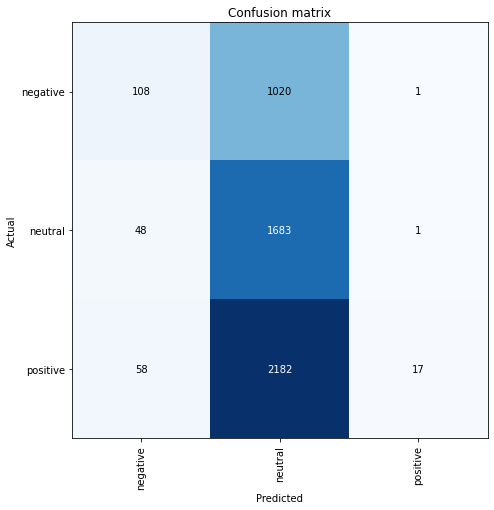

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(dls_clas.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

#### Test set

In [35]:
#data_test = TextDataLoaders.from_df(df_test, text_col='text', label_col="sentiment", text_vocab=dls_lm.vocab)
#test_dl = learn.dls.test_dl(df_test)
#preds, y = learn.get_preds()

In [36]:
dl_test = learn.dls.test_dl(df_test, with_labels=True, drop_last=False)
preds = learn.get_preds(dl=dl_test, with_decoded=True)
predictions = preds[2]
targets = preds[1]

In [37]:
#learn.dls.train.items 

In [38]:
#print(preds[2].shape)
#print(preds[1].shape)

In [39]:
def my_accuracy(y_pred, y_true):
    equ = [1 if i == t else 0 for i, t in zip(y_pred, y_true)]
    return np.mean(equ)

In [40]:
acc = my_accuracy(predictions, targets)
print("Test Set Accuracy: ",acc) #0.723

Test Set Accuracy:  0.35326299335678


In [41]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(targets, predictions)

In [42]:
#df_test.text

In [43]:
#Tried cleaning up data: via function clean_text, didn't improve a thing :(

In [66]:
df_test2 = pd.read_csv("data/private-test-set.csv", names = ["ID", "text"], encoding = "ISO-8859-1")
dl_test2 = learn.dls.test_dl(df_test2, with_labels=False, drop_last=False)
preds = learn.get_preds(dl=dl_test2, with_decoded=True)
predictions = preds[2]
targets = preds[1]

In [67]:
preds

(tensor([[1.5398e-03, 9.9697e-01, 1.4942e-03],
         [1.6272e-01, 8.2352e-01, 1.3761e-02],
         [8.2937e-04, 9.9424e-01, 4.9352e-03],
         ...,
         [1.3405e-02, 9.5005e-01, 3.6542e-02],
         [3.1270e-01, 6.7063e-01, 1.6671e-02],
         [1.5946e-02, 9.7532e-01, 8.7301e-03]]),
 None,
 tensor([1, 1, 1,  ..., 1, 1, 1]))

In [68]:
predictions[-200:]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [78]:
px = predictions.numpy()
px = pd.DataFrame(px, columns = ["label"])

In [79]:
#px["ID"] = df_test2["ID"]
px.index.rename("ID", inplace=True)
px

,label
ID,
0,1
1,1
2,1
3,1
4,1
...,...
11996,1
11997,1
11998,1


In [81]:
px.to_csv("results.csv")

In [45]:
#>>Done>> #Try other model instead of AWD_LSTM > AWD_QRNN. Didnt work. Pytorch error, too complicated fix.: https://forums.fast.ai/t/cant-import-qrnn-or-qrnnlayer/45072/7
#>>Done>> #Try make test set as validation set in classifier.
#>>DONE>> Conclusion: Use test as valid. #See test accuracy change, after proper acc calc now, afte rreverting previous step
#>>DONE>> check the other dataset for LM, not Reuters titles but perhaps better data for LM there
#>>DONE>> #Bloomberg better. But data needs stripping down:
#>>DONE>> #-first rows untill www.bloomberg.com
#>>DONE>> #-last trows from . "To contact the reporters" or/and "NOTE 1:"
#Split classifier and language model into separate notebooks
#Run the same cleaner preproccessing functions in LM as in train/test data for classifiers.
#Add preproccesing / cleaner functions into the pipeline?